In [3]:
pip install seaborn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

with open("C:/Users/Sonwa/AI_OA/data/user-wallet-transactions.json") as f:
    raw = json.load(f)

records = []
for tx in raw:
    wallet = tx["userWallet"]
    ts = pd.to_datetime(tx["timestamp"], unit="s")
    action = tx["action"]
    amount_raw = float(tx["actionData"]["amount"])
    price_usd = float(tx["actionData"].get("assetPriceUSD", 1))
    symbol = tx["actionData"].get("assetSymbol", "")
    decimals = 6 if symbol in ["USDC", "USDT"] else 18
    amount_usd = (amount_raw / (10**decimals)) * price_usd

    records.append({
        "wallet": wallet,
        "timestamp": ts,
        "action": action,
        "amount_usd": amount_usd,
        "day": ts.date()
    })

df = pd.DataFrame(records)

df.head()


,wallet,timestamp,action,amount_usd,day
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,2021-08-17 05:29:26,deposit,1987.663655,2021-08-17
1,0x000000000051d07a4fb3bd10121a343d85818da6,2021-05-20 15:36:53,deposit,285.694480,2021-05-20
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2021-07-24 09:28:33,deposit,0.000922,2021-07-24
3,0x000000000096026fb41fc39f9875d164bd82e2dc,2021-07-31 23:15:18,deposit,0.004230,2021-07-31
4,0x0000000000e189dd664b9ab08a33c4839953852c,2021-04-19 15:25:07,redeemunderlying,0.502616,2021-04-19


In [5]:
print(f"Total transactions: {len(df)}")
print(f"Unique wallets: {df['wallet'].nunique()}")
print(f"Time range: {df['timestamp'].min()} → {df['timestamp'].max()}")

df.describe()


Total transactions: 100000
Unique wallets: 3497
Time range: 2021-03-31 17:00:04 → 2021-09-02 17:54:35


,timestamp,amount_usd
count,100000,1.000000e+05
mean,2021-06-17 00:55:30.034620160,1.892399e+04
min,2021-03-31 17:00:04,0.000000e+00
25%,2021-05-21 08:21:36.500000,1.706781e+01
50%,2021-06-11 12:43:53,2.056511e+02
75%,2021-07-12 02:29:14,2.971172e+03
max,2021-09-02 17:54:35,1.274226e+07
std,NaN,1.865005e+05


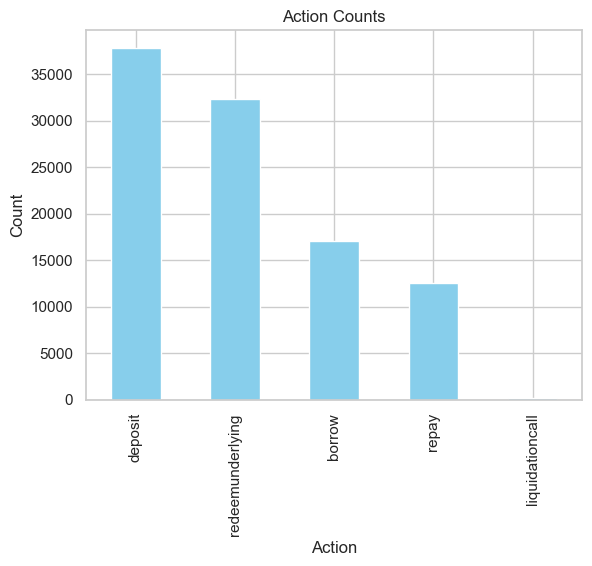

In [6]:
df["action"].value_counts().plot(kind="bar", color="skyblue")
plt.title("Action Counts")
plt.xlabel("Action")
plt.ylabel("Count")
plt.show()



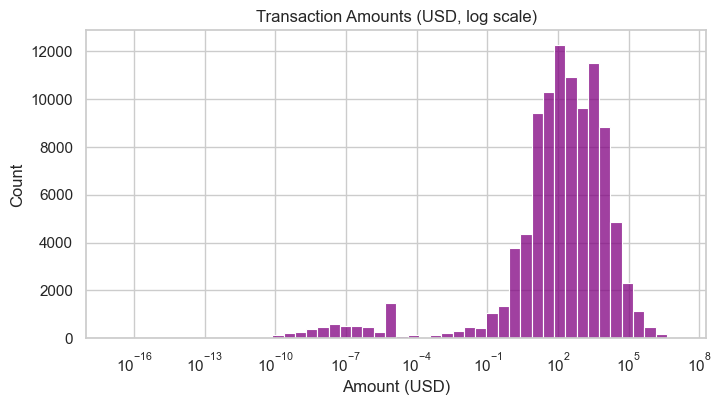

Amounts (USD) Summary:


count    1.000000e+05
mean     1.892399e+04
std      1.865005e+05
min      0.000000e+00
25%      1.706781e+01
50%      2.056511e+02
75%      2.971172e+03
max      1.274226e+07
Name: amount_usd, dtype: float64

In [7]:
plt.figure(figsize=(8,4))
sns.histplot(df["amount_usd"], bins=50, log_scale=True, color="purple")
plt.title("Transaction Amounts (USD, log scale)")
plt.xlabel("Amount (USD)")
plt.show()

print("Amounts (USD) Summary:")
df["amount_usd"].describe()


In [8]:
wallets = df.groupby("wallet").agg(
    n_tx=("action", "count"),
    n_deposits=("action", lambda x: (x=="deposit").sum()),
    n_borrows=("action", lambda x: (x=="borrow").sum()),
    n_repays=("action", lambda x: (x=="repay").sum()),
    n_liquidations=("action", lambda x: (x=="liquidationcall").sum()),
    total_deposit_usd=("amount_usd", lambda x: x[df.loc[x.index,"action"]=="deposit"].sum()),
    total_borrow_usd=("amount_usd", lambda x: x[df.loc[x.index,"action"]=="borrow"].sum()),
    total_repay_usd=("amount_usd", lambda x: x[df.loc[x.index,"action"]=="repay"].sum()),
    active_days=("day", "nunique")
).reset_index()

wallets.head()


,wallet,n_tx,n_deposits,n_borrows,n_repays,n_liquidations,total_deposit_usd,total_borrow_usd,total_repay_usd,active_days
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1,1,0,0,0,1987.663655,0.000000,0.000000,1
1,0x000000000051d07a4fb3bd10121a343d85818da6,1,1,0,0,0,285.694480,0.000000,0.000000,1
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,2,0,0,0,0.005152,0.000000,0.000000,2
3,0x0000000000e189dd664b9ab08a33c4839953852c,17,0,0,0,0,0.000000,0.000000,0.000000,8
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,399,250,15,4,0,925490.696960,130355.754756,70150.263791,104


In [9]:
wallets["borrow_to_deposit_ratio"] = wallets["total_borrow_usd"] / wallets["total_deposit_usd"]
wallets["repay_to_borrow_ratio"] = wallets["total_repay_usd"] / wallets["total_borrow_usd"]
wallets["liquidation_rate"] = wallets["n_liquidations"] / wallets["n_borrows"]

wallets.fillna(0, inplace=True)

wallets.describe()


C:\Users\Sonwa\AppData\Roaming\Python\Python311\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\Sonwa\AppData\Roaming\Python\Python311\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,n_tx,n_deposits,n_borrows,n_repays,n_liquidations,total_deposit_usd,total_borrow_usd,total_repay_usd,active_days,borrow_to_deposit_ratio,repay_to_borrow_ratio,liquidation_rate
count,3497.000000,3497.000000,3497.000000,3497.000000,3497.000000,3.497000e+03,3.497000e+03,3.497000e+03,3497.000000,3497.000000,3497.00000,3497.000000
mean,28.595939,10.811553,4.885902,3.589648,0.070918,1.644947e+05,1.156809e+05,8.757272e+04,6.563912,inf,inf,0.016064
std,250.732075,29.868997,15.133573,13.374770,0.692889,2.092775e+06,1.448302e+06,1.176703e+06,12.529142,NaN,NaN,0.156561
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,0.000000,0.00000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.047699e+00,0.000000e+00,0.000000e+00,1.000000,0.000000,0.00000,0.000000
50%,3.000000,2.000000,0.000000,0.000000,0.000000,3.580069e+01,0.000000e+00,0.000000e+00,2.000000,0.000000,0.00000,0.000000
75%,16.000000,6.000000,3.000000,2.000000,0.000000,3.750838e+03,8.373579e+02,4.068610e+02,5.000000,0.418785,0.65041,0.000000
max,14265.000000,511.000000,200.000000,291.000000,26.000000,6.167728e+07,4.703976e+07,4.690745e+07,112.000000,inf,inf,4.000000


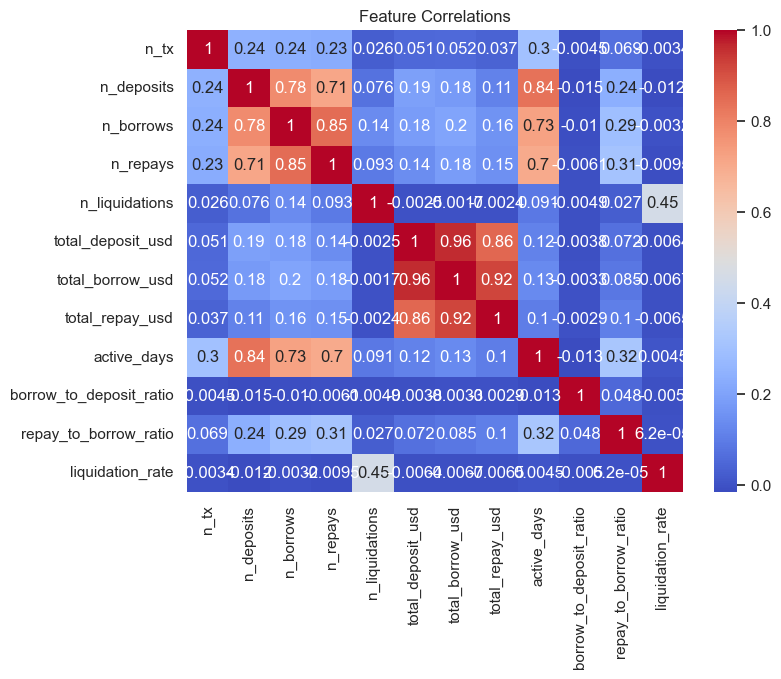

In [10]:
plt.figure(figsize=(8,6))
sns.heatmap(wallets.drop(columns=["wallet"]).corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlations")
plt.show()
